# look at pre-trained-test


# Train multiple models on tiles
Use the fastai package to:
1. Check if their lr schedule, models, etc. perform resonably compared to pytorch implementation in "tile_classifier"
2. Get idea of which models performs best 
3. See if ensembling models is useful, given that they are all trained on the same data
  1. Try training the same model multiple times with same data and ensembling
  2. Training different models and ensembling
  
  
** All of this is using the fastai conda env **

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from torchvision import datasets, models, transforms

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import os
import sys
# Base Directory where data is stored
# PATH = '/media/rene/Data/camelyon_out/tiles_299_100t'
PATH = '/media/rene/Data/camelyon_out/tiles_299_100t/'

MODEL_PATH = 'media/rene/Data/camelyon_out/trained_models'

fast_ai_dir = '/media/rene/Data/fastai/'
sys.path.append(fast_ai_dir)

# Set it to use GPU0
torch.cuda.set_device(0)
print(torch.cuda.is_available())
print(torch.cuda.current_device())

True
0


In [2]:
# put the models trained on a dataset in it
if not os.path.exists(os.path.join(PATH,'models')):
    os.makedirs(os.path.join(PATH,'models'))
if not os.path.exists(os.path.join(PATH,'sample')):
    os.makedirs(os.path.join(PATH,'sample'))

## Test a couple learning rate schedules
* Get an idea what works, can use as a starting point for all models

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 70%|███████   | 913/1302 [03:13<01:22,  4.71it/s, loss=1.32] 

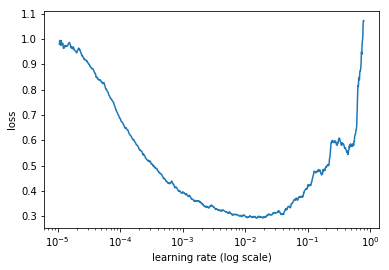

In [8]:
sz=224 # downsample to the same size for resnet
arch=resnet34
# look at 64 batch size, because this is what we will be using:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), bs=64)  
learn = ConvLearner.pretrained(arch, data, precompute=False)
lrf=learn.lr_find(start_lr=1e-5, end_lr=100)
learn.sched.plot(n_skip=5, n_skip_end=1)

Rate of change of loss is steepest around .0005, and largest acceptable is .005

## Fastai way

In [9]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
lr =.001

In [10]:
arch=resnet50
tfms = tfms_from_model(resnet50, 224, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [11]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

  0%|          | 0/2604 [00:00<?, ?it/s]                     


Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.247132   0.20892    0.910603  
    1      0.237638   0.199524   0.914435                      



[0.1995242, 0.9144345237605873]

In [12]:
lrs = np.array([lr/10,lr/5,lr])

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.224544   0.170514   0.928742  
    1      0.176723   0.156928   0.933592                      
    2      0.173413   0.155261   0.933831                      
    3      0.170709   0.155607   0.932942                      
    4      0.141842   0.14485    0.940955                      
    5      0.153905   0.146337   0.941964                      
    6      0.199034   0.152068   0.937543                      



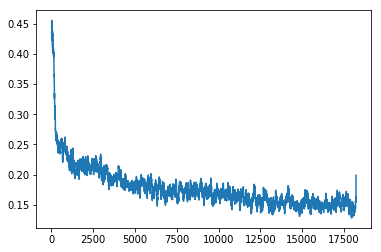

In [13]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name='resnet50_full_fastai')
learn.sched.plot_loss()

In [ ]:
# add in the bigger dataset to see if it improves performance (same train/valid split so will be fine)
PATH = '/media/rene/Data/camelyon_out/tiles_224_1m/'

arch=resnet50
tfms = tfms_from_model(arch, 224, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=False)

learn.load('/media/rene/Data/camelyon_out/tiles_224_100t/models/resnet50_full_fastai')

lr =.001
lrs = np.array([lr/10,lr/5,lr])
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2, best_save_name='resnet50_full_fastai_1m')
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  1%|          | 200/26031 [01:42<3:40:24,  1.95it/s, loss=0.139]

In [6]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_1m/'

arch=resnet50
tfms = tfms_from_model(arch, 224, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('/media/rene/Data/camelyon_out/tiles_224_100t/models/resnet50_full_fastai')
preds, y = learn.predict_with_targs(is_test=False)
print('100t validation set w/ 100t model: ',accuracy_np(preds, y))

arch=resnet50
tfms = tfms_from_model(arch, 224, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('/media/rene/Data/camelyon_out/tiles_224_1m/models/resnet50_full_fastai_1m')
preds, y = learn.predict_with_targs(is_test=False)
print('100t validation set with 1m model: ', accuracy_np(preds, y))

PATH = '/media/rene/Data/camelyon_out/tiles_224_10/'
arch=resnet50
tfms = tfms_from_model(arch, 224, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('/media/rene/Data/camelyon_out/tiles_224_1m/models/resnet50_full_fastai_1m')
preds, y = learn.predict_with_targs(is_test=False)
print('1m validation set with 1m model: ', accuracy_np(preds, y))

100t validation set w/ 100t model:  0.9265868263473054
100t validation set with 1m model:  0.9337724550898203
1m validation set with 1m model:  0.9337724550898203


## Try a couple learning rates to see what works best
####  Resnet50 is probably most standard model, so test this
* Use resonable augmentation, try learning rate schedules
* Test out:
  1. Adam
  2. SGD with restarts
  3. SGD with restarts (differential rates)

### Fine tuning all weights with same learning rate

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.261478   0.221792   0.8981    
    1      0.230505   0.215711   0.902393                    
    2      0.224545   0.21251    0.90293                     
    3      0.223911   0.210358   0.9046                      
    4      0.222573   0.214807   0.902155                    



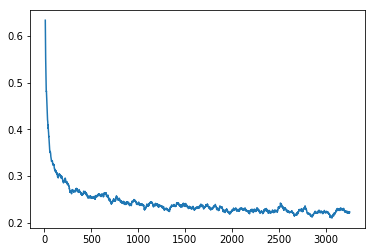

In [2]:
lr = .001
arch=resnet50
tfms = tfms_from_model(resnet50, 224, aug_tfms=transforms_top_down, max_zoom=1)

data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=128)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(lr,  5)
plt.figure()
learn.sched.plot_loss()

### Only fine tuning last layer

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.249331   0.215946   0.901976  
    1      0.232268   0.213324   0.903415                    
    2      0.23804    0.207208   0.903535                    
    3      0.210441   0.20596    0.906747                    
    4      0.218386   0.202429   0.907642                    



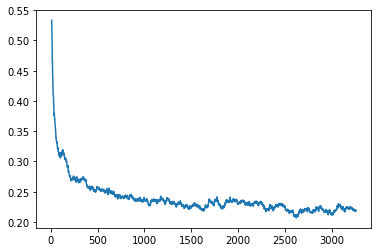

In [3]:
lr=np.array([0, 0, .001])
arch=resnet50
tfms = tfms_from_model(resnet50, 224, aug_tfms=transforms_top_down, max_zoom=1)

data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=128)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(lr,  5)
plt.figure()
learn.sched.plot_loss()

## ???
Does zoom help?
Does the size matter? does resccaling matter? For each model.
Does SGDR help?

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.477191   0.426447   0.834684  
    1      0.408415   0.334728   0.865934                  
    2      0.356127   0.322758   0.881559                  
    3      0.327712   0.312839   0.889082                  
    4      0.298398   0.296792   0.906636                  
    5      0.275332   0.295455   0.911844                  
    6      0.272501   0.291814   0.911844                  



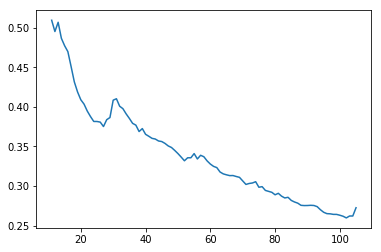

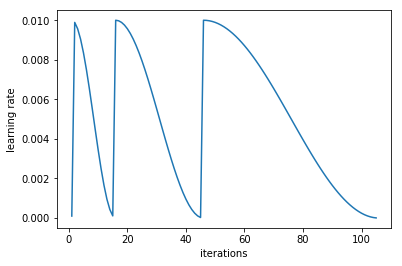

In [25]:
lr = 1e-2
arch=resnet50
tfms = tfms_from_model(resnet50, 224, aug_tfms=transforms_top_down, max_zoom=1.2)

data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
plt.figure()
learn.sched.plot_loss()
plt.figure()
learn.sched.plot_lr()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.458065   0.443597   0.853202  
    1      0.365004   0.307066   0.9076                    
    2      0.31245    0.300636   0.902392                  
    3      0.28995    0.308978   0.891975                  
    4      0.275957   0.295569   0.902392                  
    5      0.263282   0.28586    0.9076                    
    6      0.25826    0.282103   0.9076                    



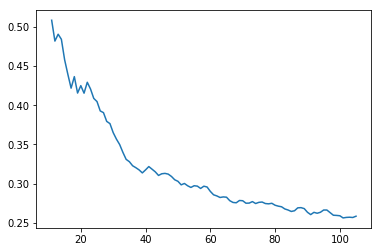

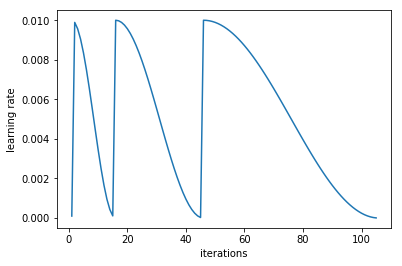

In [23]:
# Maybe we don't want zooming?
lr=np.array([1e-4,1e-3,1e-2])

arch=resnet50
tfms = tfms_from_model(resnet50, 224, aug_tfms=transforms_top_down, max_zoom=1)

data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
plt.figure()
learn.sched.plot_loss()
plt.figure()
learn.sched.plot_lr()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.527739   0.590998   0.821952  
    1      0.403714   0.305474   0.897184                  
    2      0.361575   0.31779    0.886767                  
    3      0.312174   0.307188   0.896219                  
    4      0.293638   0.304442   0.9076                    
    5      0.273597   0.292021   0.918017                  
    6      0.253758   0.296925   0.912809                  



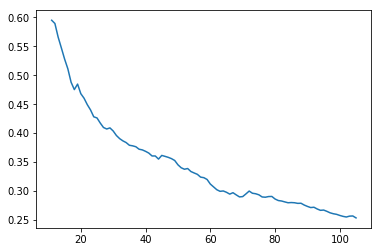

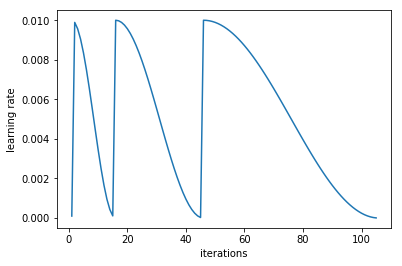

In [28]:
# Maybe we don't want zooming?
lr=np.array([1e-3,5e-3,1e-2])

arch=resnet50
tfms = tfms_from_model(resnet50, 224, aug_tfms=transforms_top_down, max_zoom=1)

data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
plt.figure()
learn.sched.plot_loss()
plt.figure()
learn.sched.plot_lr()

# Test models individually to get an idea of performance
models:
* resnet34
* resnet50
* resnet101
* vgg16
* resnext50
* resnext101
* inceptionresnet_2
* inception_4
* dn121
* dn169

** Does it matter if we read in the 224x224, or scale the 299x299? ** 

In [ ]:
models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, inception_4, dn121, dn169]
models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']

lr=np.array([1e-3,5e-3,1e-2])

for idx, arch in enumerate(models):
    if arch in [inceptionresnet_2, inception_4]:
        sz = 299
        PATH = '/media/rene/Data/camelyon_out/tiles_299_100t'
    else:
        sz = 224
        PATH = '/media/rene/Data/camelyon_out/tiles_299_100t'

    tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1.2)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms)
    
    print(models_name[idx])
    learn = ConvLearner.pretrained(arch, data, precompute=False)
    learn.fit(lr, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name[idx])

resnet34


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  0%|          | 0/1302 [00:00<?, ?it/s]                  


Exception in thread Thread-420:
Traceback (most recent call last):
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.255341   0.231327   0.895518  
    1      0.253622   0.231133   0.893491                      
    2      0.242353   0.224276   0.898388                      
    3      0.248091   0.227568   0.89899                       
    4      0.258412   0.215891   0.903716                      
    5      0.235607   0.214045   0.902698                      
    6      0.227546   0.212328   0.903776                      

resnet50


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.236542   0.208497   0.905152  
    1      0.229533   0.193573   0.910189                      
    2      0.21807    0.19953    0.908928                      
    3      0.222059   0.203794   0.906294                      
    4      0.208814   0.193822   0.913586                      
    5      0.207671   0.193967   0.912153                      
    6      0.209226   0.188228   0.916994                      

resnet101


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.237373   0.207407   0.902522  
    1      0.227158   0.190388   0.914376                      
    2      0.215104   0.187965   0.915274                      
    3      0.219308   0.190654   0.913418                      
    4      0.211119   0.179419   0.918866                      
    5      0.213924   0.179406   0.92138                       
    6      0.201884   0.180645   0.92132                       

vgg16


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.266662   0.232219   0.893718  
    1      0.249728   0.224433   0.898867                      
    2      0.254703   0.215796   0.902279                      
    3      0.244774   0.216093   0.90198                       
    4      0.254539   0.222483   0.895993                      
    5      0.237156   0.208507   0.905803                      
    6      0.230583   0.208373   0.904785                      

resnext50


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.223736   0.207713   0.905456  
    1      0.220997   0.195159   0.914017                      
    2      0.223653   0.191198   0.91677                       
    3      0.224033   0.188591   0.915633                      
    4      0.212011   0.184905   0.918143                      
    5      0.203431   0.185212   0.916531                      
    6      0.210347   0.18279    0.9197                        

resnext101


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.23134    0.194227   0.913119  
    1      0.226533   0.189073   0.913957                      
    2      0.206577   0.18417    0.917609                      
    3      0.211413   0.190894   0.91246                       
    4      0.207527   0.180603   0.922039                      
    5      0.213245   0.182499   0.918746                      
    6      0.197984   0.178461   0.920243                      

inceptionresnet_2


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.247449   0.228005   0.897071  
    1      0.247835   0.221427   0.903177                      
    2      0.241098   0.211291   0.905811                      
    3      0.230133   0.212111   0.908086                      
  6%|▌         | 81/1302 [00:40<10:04,  2.02it/s, loss=0.239]

## Test Models:

In [4]:
def get_ensemble_acc(models, models_name, PATH, weights=None):
    # weights must be in the same order corresponding to model
    if weights is None:
        weights = [1/len(models)]*len(models)
    all_preds = []
    
    for idx, arch in enumerate(models):
        if arch in [inceptionresnet_2, inception_4]:
            sz = 299
        else:
            sz = 224

        tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1)
        data = ImageClassifierData.from_paths(PATH, tfms=tfms)

        model_loc = os.path.join(PATH, 'models', models_name[idx])
        learn = ConvLearner.pretrained(arch, data, precompute=False)
        learn.load(model_loc)
        preds, y = learn.predict_with_targs(is_test=False)
        print(models_name[idx], ':   ', accuracy_np(preds, y))
        all_preds.append(preds)
        
    all_preds = np.array(all_preds)
    probs = np.average(np.exp(all_preds), axis=0, weights=weights)
    print(accuracy_np(probs, y))

In [83]:
models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, inception_4, dn121, dn169]
models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']
PATH = '/media/rene/Data/camelyon_out/tiles_299_100t/'

get_ensemble_acc(models, models_name, PATH)

resnet34 :    0.9037724550898204
resnet50 :    0.9170059880239521
resnet101 :    0.921377245508982
vgg16 :    0.905808383233533
resnext50 :    0.9197005988023952
resnext101 :    0.9220359281437126
inceptionresnet_2 :    0.9138323353293413
inception_4 :    0.9017365269461077
dn121 :    0.9202994011976048
dn169 :    0.9243712574850299
0.9224550898203593


### Try with removing the worst models

In [15]:
models_arch = [resnet50, resnet101, resnext50, resnext101, inceptionresnet_2, dn121, dn169]
models_name = ['resnet50', 'resnet101', 'resnext50', 'resnext101', 'inceptionresnet_2', 'dn121', 'dn169']

get_ensemble_acc(models_arch, models_name, PATH)

resnet50 :    0.9170059880239521
resnet101 :    0.921377245508982
resnext50 :    0.9197005988023952
resnext101 :    0.9220359281437126
inceptionresnet_2 :    0.9138323353293413
dn121 :    0.9202994011976048
dn169 :    0.9243712574850299
0.9273652694610779


### Weighted average for ensemble

In [ ]:
perf = [0.9037, 0.917, 0.921, 0.9058, 0.9197, 0.922, 0.913, 0.901, 0.920, 0.924]
perf = [1-x for x in perf]
perf = np.power(perf, 1)
weights = perf/(len(perf)*np.mean(perf))
print(weights)

In [19]:
models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, inception_4, dn121, dn169]
models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']

get_ensemble_acc(models_arch, models_name, PATH, weights)

resnet34 :    0.9037724550898204
resnet50 :    0.9170059880239521
resnet101 :    0.921377245508982
vgg16 :    0.905808383233533
resnext50 :    0.9197005988023952
resnext101 :    0.9220359281437126
inceptionresnet_2 :    0.9138323353293413
inception_4 :    0.9017365269461077
dn121 :    0.9202994011976048
dn169 :    0.9243712574850299
0.9211976047904191


In [5]:
perf = [0.9037, 0.917, 0.921, 0.9058, 0.9197, 0.922, 0.913, 0.901, 0.920, 0.924]
perf = [1-x for x in perf]
perf = np.power(perf, 4)
weights = perf/(len(perf)*np.mean(perf))
print(weights)

models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, inception_4, dn121, dn169]
models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']

get_ensemble_acc(models_arch, models_name, PATH, weights)

[0.15429 0.08514 0.06988 0.14126 0.07459 0.0664  0.10278 0.17233 0.07348 0.05985]
resnet34 :    0.9037724550898204
resnet50 :    0.9170059880239521
resnet101 :    0.921377245508982
vgg16 :    0.905808383233533
resnext50 :    0.9197005988023952
resnext101 :    0.9220359281437126
inceptionresnet_2 :    0.9138323353293413
inception_4 :    0.9017365269461077
dn121 :    0.9202994011976048
dn169 :    0.9243712574850299
0.9196407185628742


## Train the same model multiple times - resnet34

In [7]:
models_arch = resnet34
models_name = 'resnet34'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_299_100t'

for i in range(5):
    print(i)
    tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=128)

    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    learn.fit(lr, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_'+str(i))

0


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.254224   0.243983   0.889945  
    1      0.25155    0.224462   0.898108                    
    2      0.245538   0.229374   0.895185                    
    3      0.241307   0.227773   0.898465                    
    4      0.238781   0.226091   0.895953                    
    5      0.236224   0.222337   0.89942                     
    6      0.228867   0.222782   0.898994                    

1


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.25303    0.236267   0.890303  
    1      0.241575   0.235124   0.891555                    
    2      0.231444   0.23218    0.89245                     
    3      0.241005   0.219871   0.897698                    
    4      0.240089   0.224595   0.895356                    
    5      0.229602   0.219286   0.899062                    
    6      0.230578   0.224274   0.896676                    

2


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.248402   0.249809   0.883922  
    1      0.250581   0.231077   0.891488                    
    2      0.2427     0.228099   0.893814                    
    3      0.238899   0.236376   0.891384                    
    4      0.235692   0.227526   0.894283                    
    5      0.23145    0.22216    0.897273                    
    6      0.230786   0.218849   0.899718                    

3


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.256681   0.239173   0.891905  
    1      0.241265   0.230382   0.89666                     
    2      0.241284   0.226763   0.897332                    
    3      0.240192   0.231743   0.892382                    
    4      0.229422   0.225151   0.896489                    
    5      0.232788   0.218636   0.89965                     
    6      0.232905   0.219864   0.899054                    

4


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.251089   0.242452   0.887253  
    1      0.24526    0.235694   0.88876                     
    2      0.247952   0.240224   0.886256                    
    3      0.252173   0.230077   0.893293                    
    4      0.237314   0.223379   0.89971                     
    5      0.231811   0.223312   0.897921                    
    6      0.237432   0.22538    0.897444                    



In [6]:
models_arch = [resnet34 for i in range(5)]
models_name = ['resnet34_'+str(i) for i in range(5)]

get_ensemble_acc(models_arch, models_name, PATH)

resnet34_0 :    0.8992814371257485
resnet34_1 :    0.8989221556886228
resnet34_2 :    0.8995808383233533
resnet34_3 :    0.8995808383233533
resnet34_4 :    0.8996407185628742


FileNotFoundError: [Errno 2] No such file or directory: '/media/rene/Data/camelyon_out/tiles_299_100t/models/resnet34_5.h5'

In [ ]:
models_arch = dn169
models_name = 'dn169'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_299_100t'

for i in range(10):
    print(i)
    tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms)

    learn = ConvLearner.pretrained(arch, data, precompute=False)
    learn.fit(lr, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_'+str(i))

0


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.216709   0.192454   0.913115  
 33%|███▎      | 431/1302 [01:18<02:37,  5.52it/s, loss=0.239]

In [7]:
models_arch = [dn169 for i in range(10)]
models_name = ['dn169_'+str(i) for i in range(10)]

get_ensemble_acc(models_arch, models_name, PATH)

dn169_0 :    0.9246107784431138
dn169_1 :    0.9240718562874252
dn169_2 :    0.9217365269461077
dn169_3 :    0.9230538922155689
dn169_4 :    0.9232934131736527
dn169_5 :    0.9217964071856287
dn169_6 :    0.922874251497006
dn169_7 :    0.9255688622754491
dn169_8 :    0.9238323353293413
dn169_9 :    0.9235329341317365
0.9248502994011976


## Fine-tuning models
* Previously was not the proper way to train, only fine tuned the last few layers
* setting an array of learning rates was pointless, because most of the model wasn't set to trainable.

In [ ]:
models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, inception_4, dn121, dn169]
models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']

lr=np.array([1e-3,5e-3,1e-2])

for idx, arch in enumerate(models):
    if arch in [inceptionresnet_2, inception_4]:
        sz = 299
        PATH = '/media/rene/Data/camelyon_out/tiles_299_100t'
    else:
        sz = 224
        PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'

    tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1.2)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms)
    
    print(models_name[idx])
    learn = ConvLearner.pretrained(arch, data, precompute=False)
    learn.fit(lr, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name[idx])
    
    
    
    arch=resnet50
tfms = tfms_from_model(resnet50, 224, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=32)
learn = ConvLearner.pretrained(arch, data, precompute=False)

learn.fit(lr, 2, cycle_len=1, cycle_mult=1)

lrs = np.array([lr/10,lr/5,lr])

learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name='resnet50_full_fastai')
learn.sched.plot_loss()


# Check normally trained model

In [4]:
model_loc = '/media/rene/Data/camelyon_out/trained_models/inception_100t.pth'

model_ft = models.inception_v3(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft.load_state_dict(torch.load(model_loc))

In [7]:
all_preds = []
sz = 299

# tfms = tfms_from_model(resnet50, sz, aug_tfms=None, max_zoom=1)
tfms = tfms_from_stats(imagenet_stats, 299)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner(model_ft, data, precompute=False)
learn.load(model_loc)

AttributeError: 'Inception3' object has no attribute 'path'

In [ ]:
preds, y = learn.predict_with_targs(is_test=False)
print(models_name[idx], ':   ', accuracy_np(preds, y))
all_preds.append(preds)

all_preds = np.array(all_preds)
probs = np.average(np.exp(all_preds), axis=0, weights=weights)
print(accuracy_np(probs, y))